In [19]:
import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [24]:

def load_dataset(path):
    df = pandas.read_csv(path)
    return df
   
path = './dataset/cards-cleaned-1.csv'
data = load_dataset(path)
data.head()

,filename,tick,r,g,b,button,section,label
0,cards-2hz-100ms-2.csv,36000,84.0,37.0,193.0,0.0,NaN,ambient
1,cards-2hz-100ms-2.csv,36500,83.0,36.0,192.0,0.0,NaN,ambient
2,cards-2hz-100ms-2.csv,37000,84.0,36.0,193.0,0.0,NaN,ambient
3,cards-2hz-100ms-2.csv,37500,83.0,35.0,191.0,0.0,NaN,ambient
4,cards-2hz-100ms-2.csv,38000,84.0,36.0,192.0,0.0,NaN,ambient


In [28]:
data.label.value_counts()

ambient      187
Purple        30
Black         29
Pink          29
Blue          29
Grey          28
Red           28
DarkBlue      28
PaleGreen     27
White         26
Yellow        25
Name: label, dtype: int64

In [32]:

def undersample_class(data, label='ambient', random_state=1, target = 30):
    
    data = data.copy() # avoid mutating input
    is_target = data['label'] == label
    print(data[is_target].shape)
    sampled = data[is_target].sample(n=target, random_state=random_state)
    out = pandas.concat([ data[~is_target], sampled ])
    return out

cleaned = undersample_class(data)
cleaned = cleaned.dropna(subset=['label', 'section'])
cleaned.label.value_counts()

(187, 8)


Purple       30
Black        29
Pink         29
Blue         29
Grey         28
Red          28
DarkBlue     28
PaleGreen    27
White        26
Yellow       25
Name: label, dtype: int64

In [62]:
cleaned['label'] = cleaned.label.replace({
    'Purple': 'Purple',
    'Black': 'Other',
    'Pink': 'Other',
    'Blue': 'Other',
    'Grey': 'Other',
    'Red': 'Other',
    'DarkBlue': 'Other',
    'PaleGreen': 'Other',
    'White': 'Other',
    'Yellow': 'Yellow',
    'ambient': 'Other',
})
cleaned = undersample_class(cleaned, label='Other')
cleaned.label.value_counts()

(224, 8)


Purple    30
Other     30
Yellow    25
Name: label, dtype: int64

In [63]:
from sklearn.model_selection import GroupShuffleSplit

def test_split_grouped(df, group, test_size=0.20, random_state=3):
    df = df.reset_index() # use numerical index
    groups = df[group]

    out = df.copy()
    
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for i, (train_index, test_index) in enumerate(gss.split(df, groups=groups)):

        out.loc[train_index, 'split'] = 'train'
        out.loc[test_index, 'split'] = 'test'
    
    return out

prepared = test_split_grouped(cleaned, group='filename')
prepared.split.value_counts()


train    63
test     22
Name: split, dtype: int64

(0.5, 1.1)

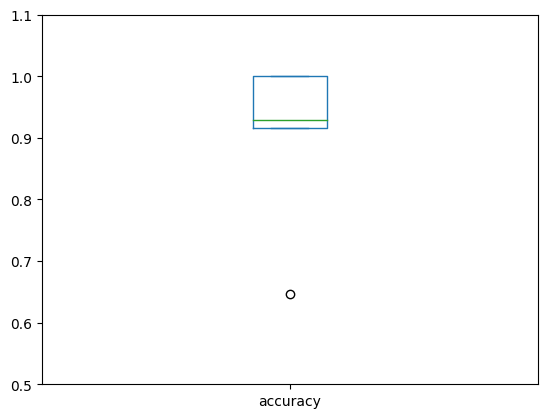

In [65]:

def evaluate_model(data, est,
                   features = ['r', 'g', 'b'],
                   group='filename',
                   scorer='accuracy',
                   random_state=3,
                   folds=10,
                   label = 'label',
                   val_size=0.2):

    X = data[features]
    Y = data[label]
    groups = data[group]

    splitter = sklearn.model_selection.GroupShuffleSplit(n_splits=folds, test_size=val_size, random_state=random_state)
    scores = cross_val_score(est, X=X, y=Y, scoring=scorer, error_score='raise', cv=splitter, groups=groups)

    res = pandas.DataFrame({
        scorer: scores,
        'fold': numpy.arange(len(scores)),
    })
    
    return res

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

import sklearn.pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer



model = RandomForestClassifier(n_estimators=10, min_samples_leaf=0.01, max_depth=5)

features = ['r', 'g', 'b']
train_data = prepared[prepared.split == 'train']
results = evaluate_model(train_data, model, features=features)

ax = results.plot(y='accuracy', kind='box')
ax.set_ylim(0.5, 1.1)

In [66]:
train_data.label.value_counts()

Purple    23
Other     21
Yellow    19
Name: label, dtype: int64

In [67]:
trained = model.fit(train_data[features], train_data['label'])
trained


RandomForestClassifier(max_depth=5, min_samples_leaf=0.01, n_estimators=10)

In [68]:
# TODO: use emlearn to convert, write C code output

In [69]:
import emlearn
print('emlearn', emlearn.__version__)

cmodel = emlearn.convert(trained)
cmodel.save(file='model.h', name='simple_rgb_pink_yellow_other');

emlearn 0.16.5
